## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) which we have fine-tuned on the TNCR dataset + foduum dataset (2332 + 238) images to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

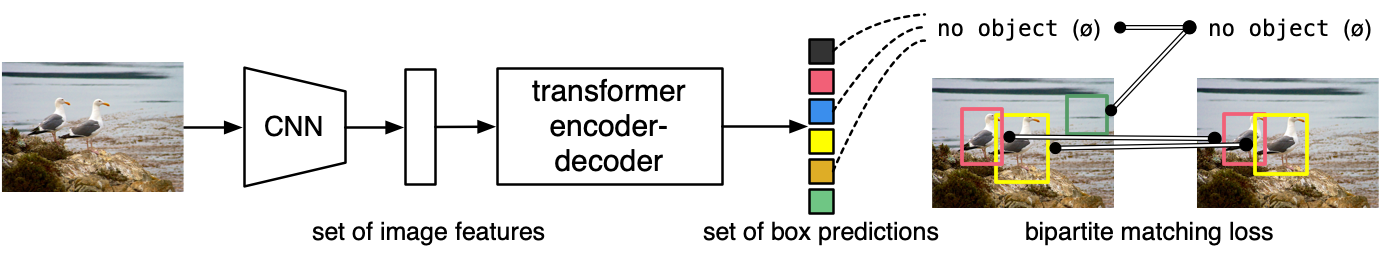


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00


In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00


## Table detection

Table detection is the task of - you guessed it - detect tables in document images, like PDFs.

Let's load a PDF and see how our model does.

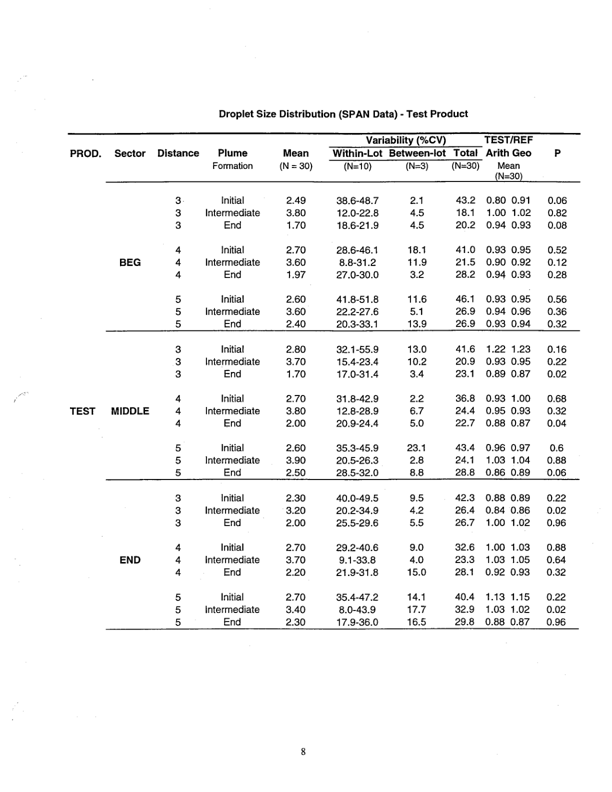

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

#file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
file_path = "test_image2.png"
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1035, 800])


## Forward pass

Next, let's send the pixel values and pixel mask through the model. We first load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

#model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("Christian710/table_detection_detr")

Some weights of the model checkpoint at Christian710/table_detection_detr were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

'''def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #text = f'{model.config.id2label[label]}: {score:0.2f}'
        #ax.text(xmin, ymin, text, fontsize=15,
                #bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results_2(pil_img, scores, boxes, label_ids, id2label):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    for score, (xmin, ymin, xmax, ymax), label_id, c in zip(scores.tolist(), boxes.tolist(), label_ids.tolist(), colors):
        label = id2label.get(label_id, 'Unknown Label')
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{label}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()




def plot_results_3(pil_img, scores, boxes, label_ids, id2label, target_label_ids):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    label_ids = torch.tensor(label_ids)  # Convert label_ids to a tensor

    for score, (xmin, ymin, xmax, ymax), label_id, c in zip(scores.tolist(), boxes.tolist(), label_ids.tolist(), colors):
        if label_id in target_label_ids:
            label = id2label.get(label_id, 'Unknown Label')
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            text = f'{label}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()'''

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results_3(pil_img, scores, boxes, label_ids, id2label, target_label_ids):
    plotted_boxes = []  # List to store the plotted bounding boxes

    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    label_ids = torch.tensor(label_ids)  # Convert label_ids to a tensor

    for score, (xmin, ymin, xmax, ymax), label_id, c in zip(scores.tolist(), boxes.tolist(), label_ids.tolist(), colors):
        if label_id in target_label_ids:
            label = id2label.get(label_id, 'Unknown Label')
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))

            plotted_boxes.append((xmin, ymin, xmax, ymax))  # Add the plotted box coordinates to the list

    plt.axis('off')
    plt.show()

    return plotted_boxes  # Return the list of plotted bounding boxes





In [ ]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.8.5, target_sizes=[(height, width)])[0]

In [ ]:
#plot_results(image, results['scores'], results['labels'], results['boxes'])

Cool! Seems like our model has correctly identified the single table present in the PDF.

In [ ]:
def crop_object(image, box):
  """Crops an object in an image

  Inputs:
    image: PIL image
    box: one box from Detectron2 pred_boxes
  """

  x_top_left = box[0, 0]
  y_top_left = box[0, 1]
  x_bottom_right = box[0, 2]
  y_bottom_right = box[0, 3]
  x_center = (x_top_left + x_bottom_right) / 2
  y_center = (y_top_left + y_bottom_right) / 2

  crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
  return crop_img

In [ ]:
results['boxes']

tensor([[ 136.4638,  255.8564, 1162.8267, 1257.0355]])

In [ ]:
image_crop = crop_object(image,results['boxes'])

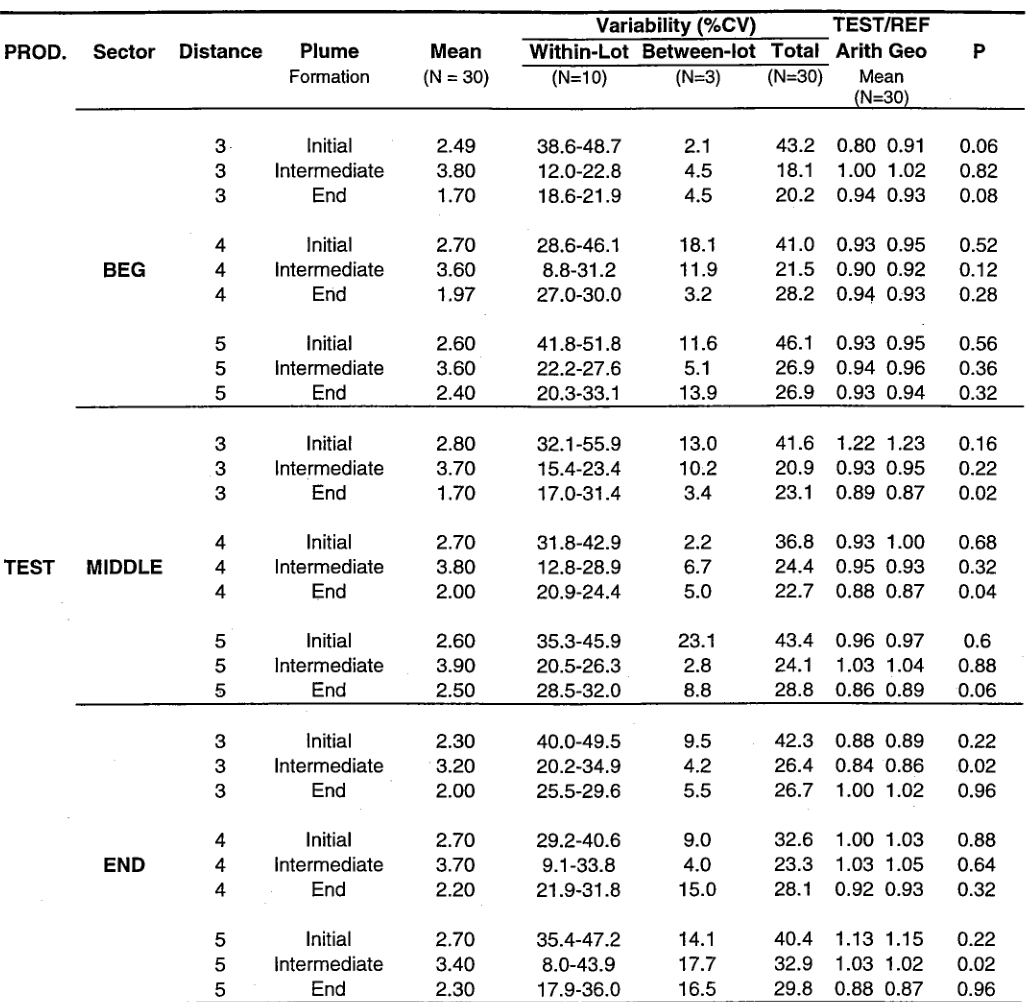

In [ ]:
image_crop

## Table structure recognition

Table structure recognition is the task of identifying the several rows, columns, cells in a table.

Let's load a demo table (which I took from the [paper](https://openaccess.thecvf.com/content/CVPR2022/html/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper.html)) and see how our model does.

In [ ]:
'''from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))'''

'from huggingface_hub import hf_hub_download\nfrom PIL import Image\n\nfile_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")\nimage = Image.open(file_path).convert("RGB")\nwidth, height = image.size\nimage.resize((int(width*0.5), int(height*0.5)))'

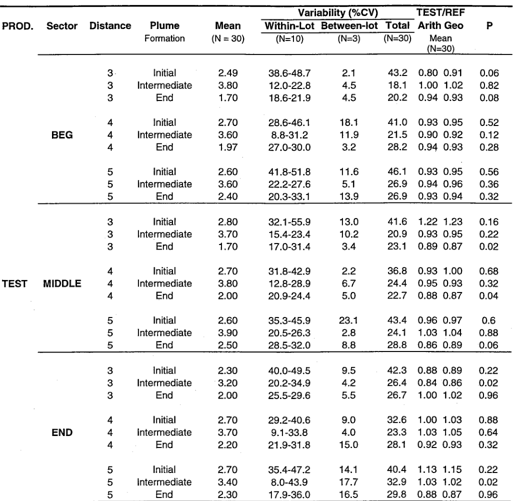

In [ ]:
image  = image_crop
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

Let's load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

#model = TableTransformerForObjectDetection.from_pretrained("bsmock/TATR-v1.1-All")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
id2label = {
    0: 'table',
    1: 'table column',
    2: 'table row',
    3: 'table column header',
    4: 'table projected row header',
    5: 'table spanning cell'
}

In [ ]:
label_ids = [2]
label_ids = torch.tensor(label_ids)
#plot_results(pil_img, scores, boxes, label_ids, id2label)

<ipython-input-8-5871a6f403ab>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = torch.tensor(label_ids)  # Convert label_ids to a tensor


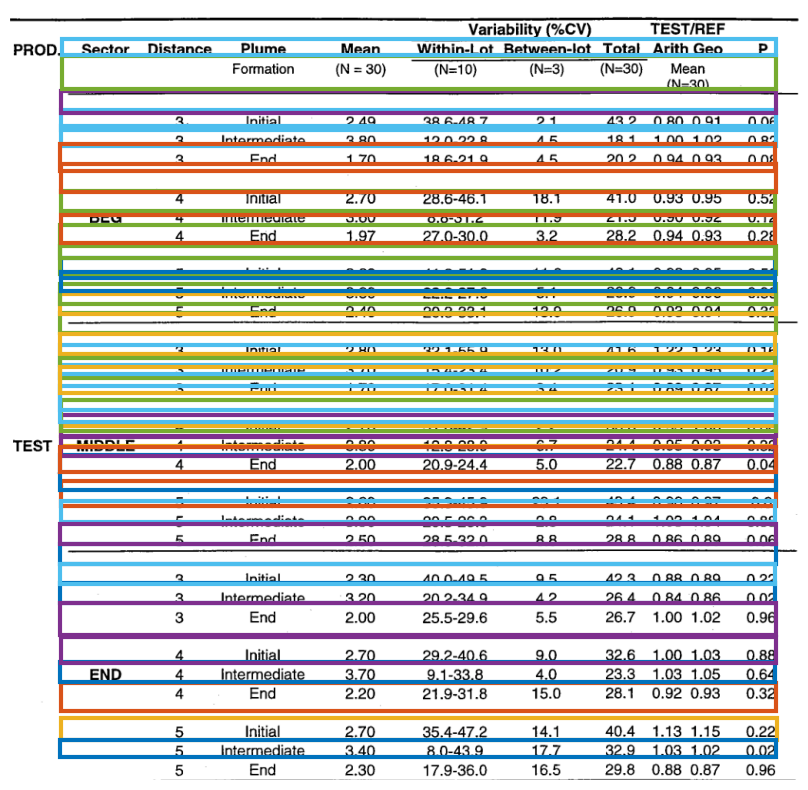

In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

#plot_results(image, results['scores'], results['labels'], results['boxes'])
#plot_results_2(image, results['scores'], results['boxes'],label_ids, id2label)
plotted_boxes = plot_results_3(image, results['scores'], results['boxes'],results['labels'], id2label, label_ids)

In [ ]:
print(plotted_boxes)

[(64.76556396484375, 745.0115966796875, 995.5245971679688, 770.8065795898438), (65.3719711303711, 920.4752807617188, 996.95263671875, 949.3953247070312), (65.51409149169922, 234.38621520996094, 995.2386474609375, 260.689697265625), (65.47286987304688, 128.994140625, 996.2911987304688, 155.0352325439453), (64.76017761230469, 693.9560546875, 995.7858276367188, 721.0618286132812), (65.26387786865234, 612.3926391601562, 995.8102416992188, 645.453857421875), (64.6235580444336, 393.884521484375, 995.9030151367188, 420.1539306640625), (64.26158905029297, 720.4929809570312, 995.5264282226562, 747.0662841796875), (65.65762329101562, 322.1272277832031, 995.37548828125, 348.0940246582031), (65.8896713256836, 541.3715209960938, 995.8861083984375, 567.4371948242188), (65.91920471191406, 104.64315795898438, 996.0161743164062, 133.7388916015625), (67.33673858642578, 58.867496490478516, 996.1060180664062, 102.52033233642578), (64.5420150756836, 435.4895324707031, 995.8295288085938, 461.6955261230469),

In [ ]:
!pip install pytesseract
!apt-get install tesseract-ocr
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (8,915 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120901 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
import pandas as pd
import pytesseract
from PIL import Image

def extract_information_from_boxes(image, plotted_boxes):
    data = []
    for box in plotted_boxes:
        xmin, ymin, xmax, ymax = box
        cropped_img = image.crop((xmin, ymin, xmax, ymax))  # Crop the image based on the box coordinates
        ocr_result = pytesseract.image_to_string(cropped_img)  # Perform OCR on the cropped image
        data.append({'Bounding Box': box, 'OCR Result': ocr_result.strip()})

    df = pd.DataFrame(data)
    return df

In [ ]:
import pandas as pd

def save_dataframe_to_file(df, file_path, file_format='csv'):
    """
    Save a DataFrame to an Excel or CSV file.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        file_path (str): The path to the output file.
        file_format (str, optional): The file format to use ('excel' or 'csv'). Default is 'csv'.
    """
    if file_format.lower() == 'excel':
        df.to_excel(file_path, index=False)
        print(f'DataFrame saved to Excel file: {file_path}')
    elif file_format.lower() == 'csv':
        df.to_csv(file_path, index=False)
        print(f'DataFrame saved to CSV file: {file_path}')
    else:
        print(f'Unsupported file format: {file_format}. Please use "excel" or "csv".')

# Example usage:
# Save the DataFrame 'result_df' to an Excel file
#save_dataframe_to_file(result_df, 'output.xlsx', file_format='excel')

# Or save it to a CSV file
#save_dataframe_to_file(result_df, 'output.csv', file_format='csv')


In [ ]:
# Example usage:
# Assuming you have 'pil_img' as the image and 'plotted_boxes' from the previous step
result_df = extract_information_from_boxes(image, plotted_boxes)
print(result_df)

                                         Bounding Box  \
0   (64.76556396484375, 745.0115966796875, 995.524...   
1   (65.3719711303711, 920.4752807617188, 996.9526...   
2   (65.51409149169922, 234.38621520996094, 995.23...   
3   (65.47286987304688, 128.994140625, 996.2911987...   
4   (64.76017761230469, 693.9560546875, 995.785827...   
5   (65.26387786865234, 612.3926391601562, 995.810...   
6   (64.6235580444336, 393.884521484375, 995.90301...   
7   (64.26158905029297, 720.4929809570312, 995.526...   
8   (65.65762329101562, 322.1272277832031, 995.375...   
9   (65.8896713256836, 541.3715209960938, 995.8861...   
10  (65.91920471191406, 104.64315795898438, 996.01...   
11  (67.33673858642578, 58.867496490478516, 996.10...   
12  (64.5420150756836, 435.4895324707031, 995.8295...   
13  (65.48201751708984, 200.30630493164062, 995.87...   
14  (64.61940002441406, 420.93743896484375, 995.58...   
15  (64.55895233154297, 770.5922241210938, 995.903...   
16  (64.82322692871094, 278.658

In [ ]:
result_df['OCR Result']
save_dataframe_to_file(result_df, 'output.csv', file_format='csv')

DataFrame saved to CSV file: output.csv


In [ ]:
results

{'scores': tensor([0.9782, 0.9999, 0.9920, 0.6646, 0.8695, 0.8866, 0.8844, 0.7327, 0.9780,
         0.9998, 0.7577, 0.9413, 0.7589, 0.9983, 0.7551, 0.8227, 0.9347, 0.7052,
         0.9990, 0.8883, 0.7919, 0.9741, 0.6266, 0.9149, 0.7223, 0.9883, 0.9995,
         0.6256, 0.6325, 0.8990, 0.7275, 0.9278, 0.7808, 0.6395, 0.6946, 0.9646,
         0.9996, 0.7139, 0.9995, 0.7665, 0.9999, 0.6804, 0.9608, 0.9913, 0.6747,
         0.9290, 0.7038, 0.9993, 0.9857, 0.8003, 0.7289, 0.9277, 0.7826, 0.6914,
         0.6799, 0.9084, 0.9502, 0.9701, 0.6849, 0.7899, 0.8969, 1.0000, 0.6892]),
 'labels': tensor([2, 1, 2, 5, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
         2, 2, 1, 2, 2, 5, 5, 2, 4, 2, 2, 2, 1, 2, 1, 5, 1, 2, 2, 3, 2, 2, 2, 1,
         2, 5, 5, 5, 2, 2, 2, 2, 5, 2, 5, 2, 5, 0, 2]),
 'boxes': tensor([[ 64.7656, 745.0116, 995.5246, 770.8066],
         [506.4823,  37.6236, 639.1652, 970.6407],
         [ 65.3720, 920.4753, 996.9526, 949.3953],
         [505.6483,  55.1659, 6

In [ ]:
import torch
from torchvision.ops import nms
import numpy as np

def post_process_table_structure(table_structure, score_threshold=0.6, iou_threshold=0.2):
    """
    Post-processes table structure detection results by filtering based on score threshold
    and applying non-maximum suppression to remove overlapping boxes.

    Args:
        table_structure (dict): A dictionary containing 'scores', 'boxes', and 'labels'.
        score_threshold (float): The minimum score a bounding box must have to be kept.
        iou_threshold (float): The intersection-over-union (IOU) threshold for non-maximum suppression.

    Returns:
        dict: A filtered table structure dictionary with 'scores', 'boxes', and 'labels'.
    """
    scores = table_structure['scores']
    boxes = table_structure['boxes']
    labels = table_structure['labels']

    # Filter boxes based on the score threshold
    high_score_indices = torch.where(scores >= score_threshold)[0]
    filtered_boxes = boxes[high_score_indices]
    filtered_scores = scores[high_score_indices]
    filtered_labels = labels[high_score_indices]

    # Apply non-maximum suppression to remove overlapping boxes
    keep = nms(filtered_boxes, filtered_scores, iou_threshold=iou_threshold)

    # Final filtered boxes, scores, and labels
    filtered_boxes = filtered_boxes[keep]
    filtered_scores = filtered_scores[keep]
    filtered_labels = filtered_labels[keep]

    filtered_results = {
        'scores': filtered_scores,
        'boxes': filtered_boxes,
        'labels': filtered_labels
    }

    return filtered_results


In [ ]:
# Example usage:
filtered_table_structure = post_process_table_structure(results, score_threshold=0.4, iou_threshold=0.2)
print(filtered_table_structure)


{'scores': tensor([1.0000, 0.9999, 0.9999, 0.9998, 0.9996, 0.9995, 0.9995, 0.9993, 0.9990,
        0.9983, 0.9920, 0.9913, 0.9883, 0.9857, 0.9782, 0.9780, 0.9741, 0.9701,
        0.9608, 0.9502, 0.9413, 0.9290, 0.9278, 0.9277, 0.9149, 0.9084, 0.8990,
        0.8969, 0.8883, 0.8866, 0.8844, 0.8695, 0.8003, 0.7919, 0.7899, 0.7826,
        0.7808, 0.7665, 0.7589, 0.7551, 0.7327, 0.7289, 0.7275, 0.7223, 0.7038,
        0.6946, 0.6849, 0.6804, 0.6646]), 'boxes': tensor([[ 66.2445,  36.6613, 995.5855, 972.1467],
        [506.4823,  37.6236, 639.1652, 970.6407],
        [940.9951,  36.6853, 995.7521, 973.3871],
        [635.8527,  37.3774, 755.7213, 972.2327],
        [877.4380,  36.5532, 941.9437, 972.9558],
        [262.5204,  37.0549, 403.1529, 972.5626],
        [402.6740,  37.2231, 508.4725, 972.4576],
        [164.3400,  37.1182, 267.0341, 973.1740],
        [ 66.4344,  37.1572, 163.9808, 973.3521],
        [752.2665,  36.8451, 826.5667, 972.9525],
        [ 65.3720, 920.4753, 996.9526,

<ipython-input-8-5871a6f403ab>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = torch.tensor(label_ids)  # Convert label_ids to a tensor


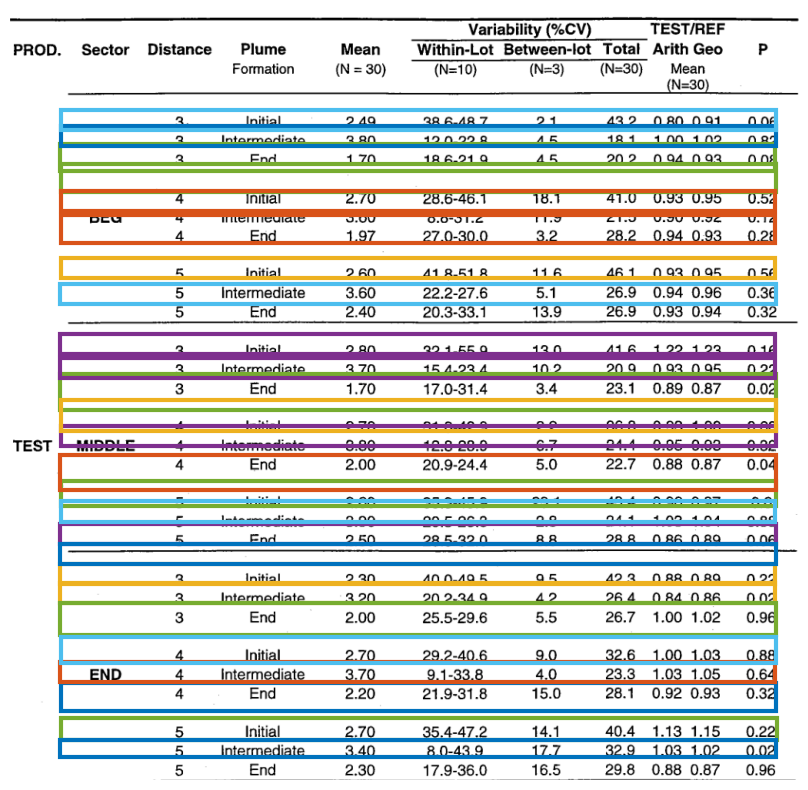

[(65.3719711303711, 920.4752807617188, 996.95263671875, 949.3953247070312),
 (65.67984771728516, 874.7747802734375, 996.3255004882812, 911.3761596679688),
 (65.0172119140625, 848.0497436523438, 995.2865600585938, 873.966064453125),
 (64.76556396484375, 745.0115966796875, 995.5245971679688, 770.8065795898438),
 (64.55895233154297, 770.5922241210938, 995.9032592773438, 813.0840454101562),
 (65.22831726074219, 815.5221557617188, 995.7760620117188, 848.923583984375),
 (65.10616302490234, 950.0116577148438, 996.7958374023438, 972.0579833984375),
 (64.26158905029297, 720.4929809570312, 995.5264282226562, 747.0662841796875),
 (64.391357421875, 668.0929565429688, 995.7736206054688, 694.4039306640625),
 (65.14273071289062, 174.26708984375, 995.5429077148438, 208.7490692138672),
 (65.24724578857422,
  150.77345275878906,
  996.0669555664062,
  176.42129516601562),
 (66.10630798339844, 266.47991943359375, 995.641357421875, 302.1696472167969),
 (65.48201751708984, 200.30630493164062, 995.879638671

In [ ]:
#plot_results(image, filtered_table_structure['scores'], filtered_table_structure['labels'], filtered_table_structure['boxes'])
plot_results_3(image, filtered_table_structure['scores'], filtered_table_structure['boxes'],filtered_table_structure['labels'], id2label, label_ids)

In [ ]:
import pandas as pd

def extract_text_with_labels(image, results, id2label, display_label_ids, layout='columns'):
    """
    Extract text using Tesseract OCR for objects that match specified label IDs
    and organize the text into a DataFrame.

    Args:
        image (PIL.Image): The input image.
        results (dict): Detection results containing 'scores', 'boxes', 'labels'.
        id2label (dict): A mapping of label IDs to label names.
        display_label_ids (list): List of label IDs to extract text for.
        layout (str): 'columns' to organize text into columns, 'rows' to organize into rows.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted text.
    """
    # Perform OCR using Tesseract
    img_text = pytesseract.image_to_string(image)

    # Initialize data for the DataFrame
    data = {'Label': [], 'Text': []}

    # Iterate over detected objects and match with specified label IDs
    for score, label_id, text in zip(results['scores'], results['labels'], img_text.splitlines()):
        if label_id in display_label_ids:
            label = id2label.get(label_id, 'Unknown Label')
            data['Label'].append(label)
            data['Text'].append(text)

    # Create a DataFrame
    df = pd.DataFrame(data)

    if layout == 'columns':
        # Pivot the DataFrame to organize text in columns
        df = df.pivot(columns='Label', values='Text').fillna('')

    return df



In [ ]:
# Example usage:
# Assuming 'pil_img', 'results', 'id2label', and 'display_label_ids' are defined
df = extract_text_with_labels(image, results, id2label, label_ids, layout='columns')
print(df)

Label                                      Unknown Label
0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6      PROD. Sector Distance Plume Mean in-Lot Betwee...
7            Formation (N= 30) (N=10) (N=3)_ (N=30) Mean
8                                                 (N=30)
9        3 Initial 2.49 38.6-48.7 21 43.2 0.80 0.91 0.06
10                                                      
11     3 Intermediate 3.80 12.0-22.8 45 18.1 1.00 1.0...
12                                                      
13                                                      
14      4 Initial 2.70 28.6-46.1 18.1 41.0 0.930.95 0.52
15                                                      
16     BEG 4 Intermediate 3.60 